# What’s In Your Customer’s Next Shopping Cart

## Predictionby using Logistic Regression

### Importing Packages

In [1]:
import pandas as pd
import numpy as np
from collections import OrderedDict

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate

In [2]:
aisles_df = pd.read_csv("/Users/Priyanka Malpekar/Downloads/Dataset/aisles.csv")
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [3]:
departments_df = pd.read_csv("/Users/Priyanka Malpekar/Downloads/Dataset/departments.csv")
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [4]:
order_products_prior_df = pd.read_csv("/Users/Priyanka Malpekar/Downloads/Dataset/order_products__prior.csv")
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [5]:
order_products_train_df = pd.read_csv("/Users/Priyanka Malpekar/Downloads/Dataset/order_products__train.csv")
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [6]:
orders_df = pd.read_csv("/Users/Priyanka Malpekar/Downloads/Dataset/orders.csv")
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [7]:
products_df = pd.read_csv("/Users/Priyanka Malpekar/Downloads/Dataset/products.csv")
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [8]:
order_products_prior_df = order_products_prior_df[:3000000]

In [9]:
order_products_prior_df

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
2999995,316715,14114,1,1
2999996,316715,41950,2,1
2999997,316715,43789,3,0
2999998,316716,6050,1,1


In [10]:
# Preliminary analysis and modeling

In [11]:
order_products_train_df = order_products_train_df.merge(orders_df.drop('eval_set', axis=1), on='order_id')
order_products_prior_df = order_products_prior_df.merge(orders_df.drop('eval_set', axis=1), on='order_id')

In [12]:
user_product_df = (order_products_prior_df.groupby(['product_id','user_id'],as_index=False) 
                                          .agg({'order_id':'count'}) 
                                          .rename(columns={'order_id':'user_product_total_orders'}))

train_ids = order_products_train_df['user_id'].unique() 
df_X = user_product_df[user_product_df['user_id'].isin(train_ids)]
df_X.head()

,product_id,user_id,user_product_total_orders
0,1,1494,1
1,1,1540,1
3,1,3904,1
6,1,11119,1
9,1,15175,1


In [13]:
train_carts = (order_products_train_df.groupby('user_id',as_index=False)
                                      .agg({'product_id':(lambda x: set(x))})
                                      .rename(columns={'product_id':'latest_cart'}))

df_X = df_X.merge(train_carts, on='user_id')
df_X['in_cart'] = (df_X.apply(lambda row: row['product_id'] in row['latest_cart'], axis=1).astype(int))

df_X.head()

,product_id,user_id,user_product_total_orders,latest_cart,in_cart
0,1,1494,1,{44560},0
1,130,1494,1,{44560},0
2,1648,1494,1,{44560},0
3,2745,1494,2,{44560},0
4,4377,1494,1,{44560},0


In [14]:
#Here I see class imbalance
df_X['in_cart'].value_counts()

0    1274115
1     257327
Name: in_cart, dtype: int64

In [15]:
#Product Features

In [16]:
prod_features = ['product_total_orders','product_avg_add_to_cart_order']

prod_features_df = (order_products_prior_df.groupby(['product_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id','nunique'),
                                                    ('add_to_cart_order','mean')])))
prod_features_df.columns = ['product_id'] + prod_features
prod_features_df.head()

,product_id,product_total_orders,product_avg_add_to_cart_order
0,1,149,6.194631
1,2,11,12.454545
2,3,12,4.750000
3,4,33,9.575758
4,5,2,6.000000


In [17]:
df_X = df_X.merge(prod_features_df, on='product_id')

#note that dropping rows with NA product_avg_days_since_prior_order is likely a naive choice 
df_X = df_X.dropna()
df_X.head()

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order
0,1,1494,1,{44560},0,149,6.194631
1,1,1540,1,"{30720, 1, 11266, 130, 40199, 21769, 6184, 900...",1,149,6.194631
2,1,3904,1,"{6184, 20818, 21572, 32478}",0,149,6.194631
3,1,11119,1,"{17122, 8803, 43352, 41400, 5769, 14477, 21903...",0,149,6.194631
4,1,15175,1,"{21572, 10310, 6184, 47402, 37710, 15672, 3077...",0,149,6.194631


In [18]:
#User Features

In [19]:
user_features = ['user_total_orders','user_avg_cartsize','user_total_products','user_avg_days_since_prior_order']

user_features_df = (order_products_prior_df.groupby(['user_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id',['nunique', (lambda x: x.shape[0] / x.nunique())]),
                                                    ('product_id','nunique'),
                                                    ('days_since_prior_order','mean')])))

user_features_df.columns = ['user_id'] + user_features
user_features_df.head()

,user_id,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order
0,4,1,2.0,2,15.000000
1,5,1,12.0,12,19.000000
2,6,1,7.0,7,6.000000
3,7,2,17.5,31,29.371429
4,9,1,30.0,30,NaN


In [20]:
df_X = df_X.merge(user_features_df, on='user_id')
df_X = df_X.dropna()
df_X.head(1)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order
0,1,1494,1,{44560},0,149,6.194631,2,23.0,38,6.543478


In [21]:
#User Product Features

In [22]:
user_prod_features = ['user_product_avg_add_to_cart_order']

user_prod_features_df = (order_products_prior_df.groupby(['product_id','user_id'],as_index=False) \
                                                .agg(OrderedDict(
                                                     [('add_to_cart_order','mean')])))

user_prod_features_df.columns = ['product_id','user_id'] + user_prod_features 
user_prod_features_df.head()

,product_id,user_id,user_product_avg_add_to_cart_order
0,1,1494,18.0
1,1,1540,10.0
2,1,3029,8.0
3,1,3904,2.0
4,1,4122,1.0


In [23]:
df_X = df_X.merge(user_prod_features_df,on=['user_id','product_id'])
df_X['user_product_order_freq'] = df_X['user_product_total_orders'] / df_X['user_total_orders'] 
df_X.head(1)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order,user_product_avg_add_to_cart_order,user_product_order_freq
0,1,1494,1,{44560},0,149,6.194631,2,23.0,38,6.543478,18.0,0.5


In [24]:
#Adding more features and complicating the model

In [25]:
#Product Features

In [26]:
#3 product features: average day of week when ordered, average day of the week, and average days since prior order
prod_features = ['product_avg_order_dow', 'product_avg_order_hour_of_day', 'product_avg_days_since_prior_order']

prod_features_df = (order_products_prior_df.groupby(['product_id'], as_index=False)
                                     .agg(OrderedDict(
                                     [('order_dow','mean'),
                                      ('order_hour_of_day', 'mean'),
                                      ('days_since_prior_order', 'mean')])))

prod_features_df.columns = ['product_id'] + prod_features
prod_features_df.head()

,product_id,product_avg_order_dow,product_avg_order_hour_of_day,product_avg_days_since_prior_order
0,1,2.637584,13.026846,11.429577
1,2,2.272727,16.000000,11.363636
2,3,2.416667,12.416667,13.333333
3,4,2.606061,13.818182,14.242424
4,5,3.000000,10.000000,7.500000


In [27]:
df_X = df_X.merge(prod_features_df, on='product_id')
df_X = df_X.dropna()
df_X.head(1)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order,user_product_avg_add_to_cart_order,user_product_order_freq,product_avg_order_dow,product_avg_order_hour_of_day,product_avg_days_since_prior_order
0,1,1494,1,{44560},0,149,6.194631,2,23.0,38,6.543478,18.0,0.5,2.637584,13.026846,11.429577


In [28]:
#User features

In [29]:
user_features = ['user_avg_order_dow','user_avg_order_hour_of_day']

user_features_df = (order_products_prior_df.groupby(['user_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_dow','mean'),
                                                    ('order_hour_of_day','mean')])))

user_features_df.columns = ['user_id'] + user_features
user_features_df.head()

,user_id,user_avg_order_dow,user_avg_order_hour_of_day
0,4,5.0,13.000000
1,5,1.0,18.000000
2,6,4.0,16.000000
3,7,0.0,15.485714
4,9,1.0,17.000000


In [30]:
df_X = df_X.merge(user_features_df, on='user_id')
df_X = df_X.dropna()
df_X.head(1)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order,user_product_avg_add_to_cart_order,user_product_order_freq,product_avg_order_dow,product_avg_order_hour_of_day,product_avg_days_since_prior_order,user_avg_order_dow,user_avg_order_hour_of_day
0,1,1494,1,{44560},0,149,6.194631,2,23.0,38,6.543478,18.0,0.5,2.637584,13.026846,11.429577,2.0,8.0


In [31]:
#User Product Features

In [32]:
user_prod_features = ['user_product_avg_days_since_prior_order',
                      'user_product_avg_order_dow',
                      'user_product_avg_order_hour_of_day']

user_prod_features_df = (order_products_prior_df.groupby(['product_id','user_id'],as_index=False) \
                                                .agg(OrderedDict(
                                                     [('days_since_prior_order','mean'),
                                                     ('order_dow','mean'),
                                                     ('order_hour_of_day','mean')])))

user_prod_features_df.columns = ['product_id','user_id'] + user_prod_features 
user_prod_features_df.head()

,product_id,user_id,user_product_avg_days_since_prior_order,user_product_avg_order_dow,user_product_avg_order_hour_of_day
0,1,1494,6.0,2.0,8.0
1,1,1540,7.0,2.0,0.0
2,1,3029,NaN,2.0,20.0
3,1,3904,NaN,1.0,14.0
4,1,4122,8.0,2.0,7.0


In [33]:
df_X = df_X.merge(user_prod_features_df, on=['user_id', 'product_id'])
df_X = df_X.dropna()
df_X.head(1)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,...,user_product_avg_add_to_cart_order,user_product_order_freq,product_avg_order_dow,product_avg_order_hour_of_day,product_avg_days_since_prior_order,user_avg_order_dow,user_avg_order_hour_of_day,user_product_avg_days_since_prior_order,user_product_avg_order_dow,user_product_avg_order_hour_of_day
0,1,1494,1,{44560},0,149,6.194631,2,23.0,38,...,18.0,0.5,2.637584,13.026846,11.429577,2.0,8.0,6.0,2.0,8.0


In [34]:
#Deltas

In [35]:
#Create delta columns to compare how users perform against averages
df_X['product_total_orders_delta_per_user'] = df_X['product_total_orders'] - df_X['user_product_total_orders']

df_X['product_avg_add_to_cart_order_delta_per_user'] = df_X['product_avg_add_to_cart_order'] - \
                                                            df_X['user_product_avg_add_to_cart_order']

df_X['product_avg_order_dow_per_user'] = df_X['product_avg_order_dow'] - df_X['user_product_avg_order_dow']

df_X['product_avg_order_hour_of_day_per_user'] = df_X['product_avg_order_hour_of_day'] - \
                                                            df_X['user_product_avg_order_hour_of_day']

df_X['product_avg_days_since_prior_order_per_user'] = df_X['product_avg_days_since_prior_order'] - \
                                                            df_X['user_product_avg_days_since_prior_order']

In [36]:
#Expand Dummies for department name

In [37]:
temp = products_df.merge(departments_df, on = 'department_id')
temp = temp[['product_id', 'department']]
temp.head()

,product_id,department
0,1,snacks
1,16,snacks
2,25,snacks
3,32,snacks
4,41,snacks


In [38]:
df_X = df_X.merge(temp, on = 'product_id')
df_X = df_X.dropna()
df_X = pd.concat([df_X, pd.get_dummies(df_X['department'])], axis=1)
del df_X['department']

In [39]:
#Use Best Model

In [40]:
np.random.seed(29)
total_users = df_X['user_id'].unique() 
test_users = np.random.choice(total_users, size=int(total_users.shape[0] * .30), replace=False)

test_user_sets = []
length = len(test_users)
cv = 10

for x in range (0, cv):
    start = int(x/cv*length)
    finish = int((x+1)/cv*length)
    test_user_sets.append(test_users[start:finish])
    
cv_f1_scores = []
cv_f1_scores_balanced = []
cv_f1_scores_10fit = []

for test_user_set in test_user_sets:
    df_X_tr, df_X_te = df_X[~df_X['user_id'].isin(test_user_set)], df_X[df_X['user_id'].isin(test_user_set)] 

    y_tr, y_te = df_X_tr['in_cart'], df_X_te['in_cart']
    X_tr, X_te = df_X_tr.drop(['product_id','user_id','latest_cart','in_cart'],axis=1), \
             df_X_te.drop(['product_id','user_id','latest_cart','in_cart'],axis=1), \
        
    scaler = MinMaxScaler()
    X_tr = pd.DataFrame(scaler.fit_transform(X_tr), columns=X_tr.columns)
    X_te = pd.DataFrame(scaler.fit_transform(X_te), columns=X_te.columns)
    
    lr = LogisticRegression(C=10000000) 
    lr_balanced = LogisticRegression(class_weight='balanced', C=10000000)
    lr_10x = LogisticRegression(class_weight={1 : 6, 0 : 1}, C=10000000)
    
    lr.fit(X_tr, y_tr)
    cv_f1_scores.append(f1_score(lr.predict(X_te), y_te))

    lr_balanced.fit(X_tr, y_tr)
    cv_f1_scores_balanced.append(f1_score(lr_balanced.predict(X_te), y_te))

    lr_10x.fit(X_tr, y_tr)
    cv_f1_scores_10fit.append(f1_score(lr_10x.predict(X_te), y_te))   

print(np.mean(cv_f1_scores))
print(np.mean(cv_f1_scores_balanced))
print(np.mean(cv_f1_scores_10fit))

df_X_tr, df_X_te = df_X[~df_X['user_id'].isin(test_users)], df_X[df_X['user_id'].isin(test_users)]

y_tr, y_te = df_X_tr['in_cart'], df_X_te['in_cart']
X_tr, X_te = df_X_tr.drop(['product_id','user_id','latest_cart','in_cart'],axis=1), \
             df_X_te.drop(['product_id','user_id','latest_cart','in_cart'],axis=1), \

lr_10x = LogisticRegression(class_weight={1 : 6, 0 : 1}, C=10000000)
lr_10x.fit(X_tr, y_tr)
f1_score(lr_10x.predict(X_te), y_te)

C:\Users\Priyanka Malpekar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Priyanka Malpekar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Priyanka Malpekar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Priyanka Malpekar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Priyanka Malpekar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will 

0.11876841203979113
0.3723117224893033
0.38143492804522405


C:\Users\Priyanka Malpekar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.3806822757464033

In [41]:
np.random.seed(43)
total_users = df_X['user_id'].unique() 
test_users = np.random.choice(total_users, size=int(total_users.shape[0] * .20), replace=False)

df_X_tr, df_X_te = df_X[~df_X['user_id'].isin(test_users)], df_X[df_X['user_id'].isin(test_users)]
                        
val_index = np.random.choice(df_X_tr.index, int(len(df_X_tr.index)/4), replace=False)
df_X_val = df_X.loc[val_index]
df_X_tr = df_X.loc[~df_X.index.isin(val_index)]                        

y_tr, y_val, y_te = df_X_tr['in_cart'], df_X_val['in_cart'], df_X_te['in_cart']
X_tr, X_val, X_te = df_X_tr.drop(['product_id','user_id','latest_cart','in_cart'],axis=1), \
             df_X_val.drop(['product_id','user_id','latest_cart','in_cart'],axis=1), \
             df_X_te.drop(['product_id','user_id','latest_cart','in_cart'],axis=1), \
        
scaler = MinMaxScaler()
X_tr = pd.DataFrame(scaler.fit_transform(X_tr), columns=X_tr.columns)
X_val = pd.DataFrame(scaler.fit_transform(X_val), columns=X_val.columns)
X_te = pd.DataFrame(scaler.fit_transform(X_te), columns=X_te.columns)
    
lr = LogisticRegression(C=10000000) 
lr_balanced = LogisticRegression(class_weight='balanced', C=10000000)
lr_10x = LogisticRegression(class_weight={1 : 6, 0 : 1}, C=10000000)
    
lr.fit(X_tr, y_tr)
cv_f1_score = f1_score(lr.predict(X_val), y_val)

lr_balanced.fit(X_tr, y_tr)
cv_f1_score_balanced = f1_score(lr_balanced.predict(X_val), y_val)

lr_10x.fit(X_tr, y_tr)
cv_f1_score_lr_10x = f1_score(lr_10x.predict(X_val), y_val)  

print(cv_f1_score)
print(cv_f1_score_balanced)
print(cv_f1_score_lr_10x)

df_X_tr, df_X_te = df_X[~df_X['user_id'].isin(test_users)], df_X[df_X['user_id'].isin(test_users)]

y_tr, y_te = df_X_tr['in_cart'], df_X_te['in_cart']
X_tr, X_te = df_X_tr.drop(['product_id','user_id','latest_cart','in_cart'],axis=1), \
             df_X_te.drop(['product_id','user_id','latest_cart','in_cart'],axis=1), \

lr_10x = LogisticRegression(class_weight={1 : 6, 0 : 1}, C=10000000)
lr_10x.fit(X_tr, y_tr)
f1_score(lr_10x.predict(X_te), y_te)

C:\Users\Priyanka Malpekar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Priyanka Malpekar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Priyanka Malpekar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.08559630059563456
0.40031107222708273
0.3967875949300098


C:\Users\Priyanka Malpekar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.38318989234139306

In [42]:
coefficients = pd.DataFrame(lr_10x.coef_, columns = X_tr.columns)
coefficients = np.exp(coefficients)
coefficients.T

,0
user_product_total_orders,1.657417
product_total_orders,1.287423
product_avg_add_to_cart_order,0.913645
user_total_orders,0.905199
user_avg_cartsize,1.036869
user_total_products,0.993214
user_avg_days_since_prior_order,0.994877
user_product_avg_add_to_cart_order,0.943689
user_product_order_freq,1.230198
product_avg_order_dow,0.957915


Training Data Accuracy: 0.59
Test Data Accuracy:     0.59
[[133228 105900]
 [ 12926  36910]]


Precision:              0.26
Recall:                 0.74


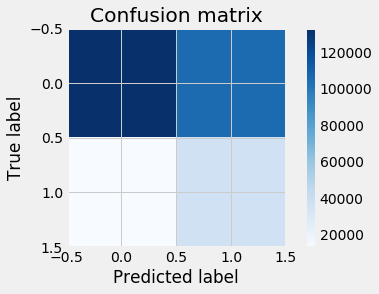

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#y_tr=np.ravel(y_tr)

train_acc=lr_10x.score(X_tr, y_tr)
test_acc=lr_10x.score(X_te, y_te)
print("Training Data Accuracy: %0.2f" %(train_acc))
print("Test Data Accuracy:     %0.2f" %(test_acc))
    
y_true = y_te
y_pred = lr_10x.predict(X_te)


conf = confusion_matrix(y_true, y_pred)
print(conf)

print ('\n')
print ("Precision:              %0.2f" %(conf[1, 1] / (conf[1, 1] + conf[0, 1])))
print ("Recall:                 %0.2f"% (conf[1, 1] / (conf[1, 1] + conf[1, 0])))
    
cm=confusion_matrix(y_true, y_pred, labels=[0, 1])
    
plt.figure()
plot_confusion_matrix(cm)

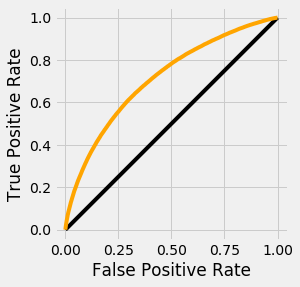

In [51]:
from sklearn.metrics import roc_curve, auc

y_score = lr_10x.predict_proba(X_te)[:,1]

fpr, tpr,_ = roc_curve(y_te, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1], linestyle='-', color = 'black')
plt.plot(fpr, tpr, color = 'orange')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.gca().set_aspect('equal', adjustable='box')